# 2nd order servo model

![diagram](../doc/diagrams/control-servo.png)


In [66]:
import numpy
import scipy.linalg
import matplotlib.pyplot as plt

#2nd order state space model
#dx = Ax + Bu

#dv   = -1.0/tau*v + amp/tau*u
#dpos = v

tau = 1.9
amp = 3.1

#fill matrices
a = numpy.zeros((2, 2))
b = numpy.zeros((2, 1))

a[0][0] = -1.0/tau
a[0][1] = 0.0
a[1][0] = 1.0
a[1][1] = 0.0

b[0][0] = amp/tau

print(a)
print(b)

[[-0.52631579  0.        ]
 [ 1.          0.        ]]
[[1.63157895]
 [0.        ]]


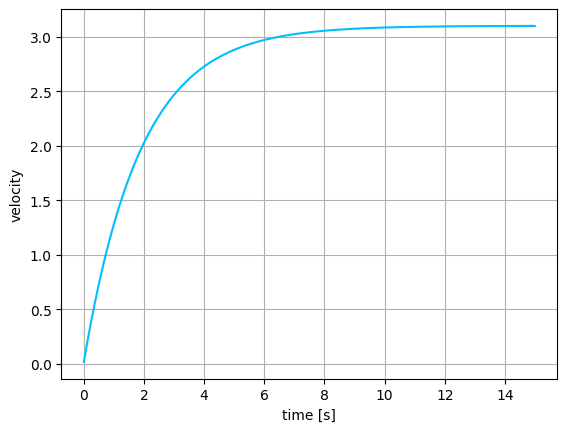

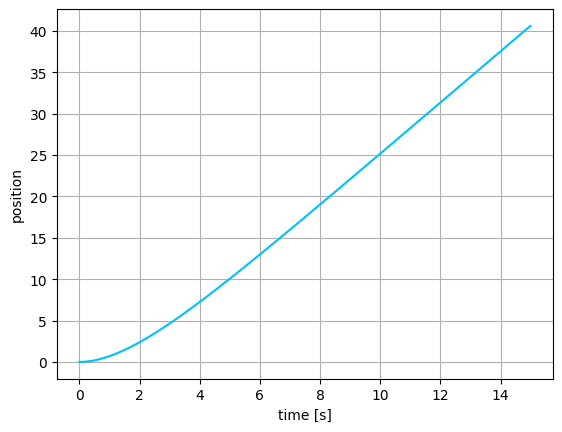

In [67]:
#open loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
x_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    dx = a@x + b@u
    x  = x + dx*dt

    x_result[i] = x[:, 0]

#plot step response
plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# LQR integral action controller design

## controller structure 

![diagram](../doc/diagrams/control-lqri_synth.png)


algorithm : 
* given system dynamics : matrices A, B
* given weighting for controlled state, Q matrix
* given weighting for controll signal u, R matrix
* - matrices Q, and R are mostly diagonal

* using Riccati equation compute matrix K
* this matrix stabiles system
* using steady state response with closed loop, compute gain scaling matrix G, which removes steady state error



In [68]:
#controller criterion : weight diagonal matrices
q = numpy.array([ [0.0, 0.0], [0.0, 1.0] ] )
r = numpy.array( [ [0.5] ]) 

#solve LQR controller

#matrix augmentation with integral action
n = a.shape[0]  #system order
m = b.shape[1]  #inputs count
k = n           #outputs count

a_aug = numpy.zeros((n+k, n+k))
b_aug = numpy.zeros((n+k, m))
q_aug = numpy.zeros((n+k, n+k))

a_aug[0:n, 0:n] = a
a_aug[n:, 0:n]  = numpy.eye(n)

b_aug[0:n,0:m]  = b

q_aug[0:n,0:n]  = 0
q_aug[k:,k:]    = q


#continnuous algebraic Riccati equation
p = scipy.linalg.solve_continuous_are(a_aug, b_aug, q_aug, r)
# compute the LQR gain matrix k
ki_tmp =  scipy.linalg.inv(r) * (b_aug.T@p) 

#split ki for k and integral action part ki
k   = ki_tmp[:, 0:a.shape[0]]
ki  = ki_tmp[:, a.shape[0]:]

#print control matrices
print(k)
print(ki)

[[1.33923651 2.16802415]]
[[1.52651804e-18 1.41421356e+00]]


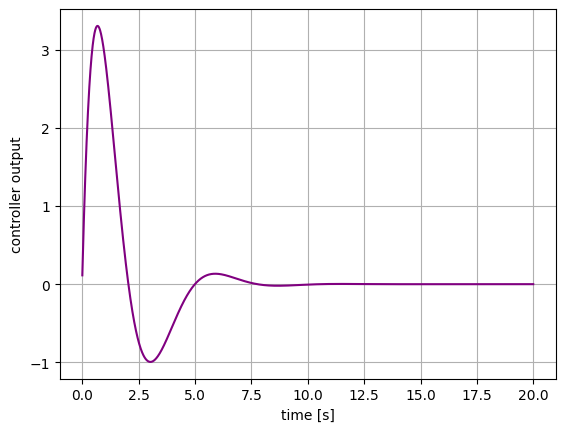

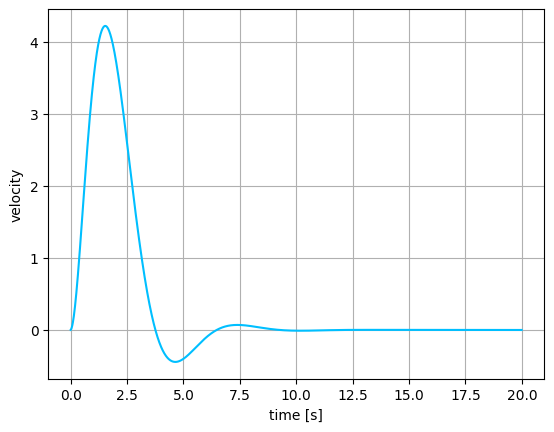

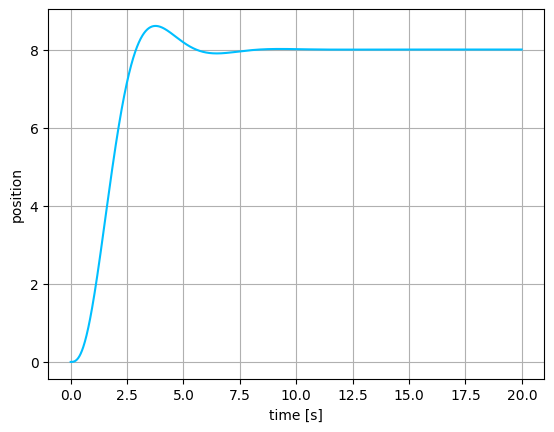

In [69]:
#closed loop step response
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))

error_sum = numpy.zeros((2, 1))

for i in range(steps):
    u = numpy.ones((1, 1))

    #error and integral action
    error = xr - x
    error_sum+= error*dt

    #apply LQR control law
    u = -k@x + ki@error_sum

    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# adding disturbance

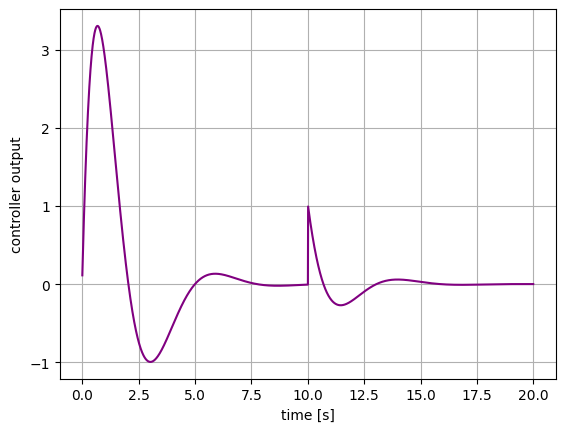

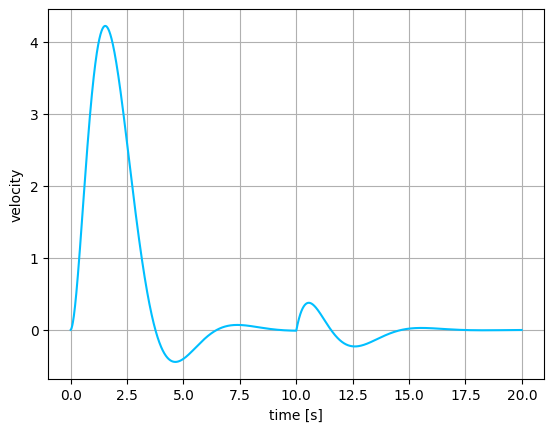

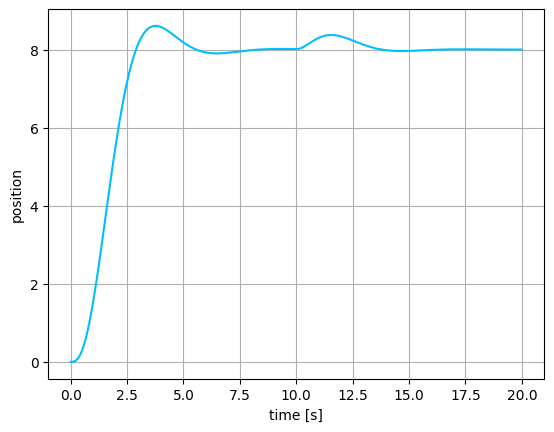

In [70]:
#closed loop step response with disturbance
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))

error_sum = numpy.zeros((2, 1))

for i in range(steps):
    u = numpy.ones((1, 1))

    #error and integral action
    error = xr - x
    error_sum+= error*dt

    #apply LQR control law
    u = -k@x + ki@error_sum

    
    # disturbance in middle
    if i > steps//2:
        u+= 1

    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt

    
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# noisy state

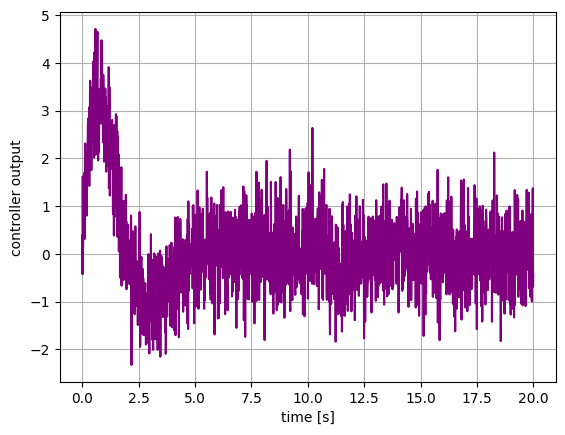

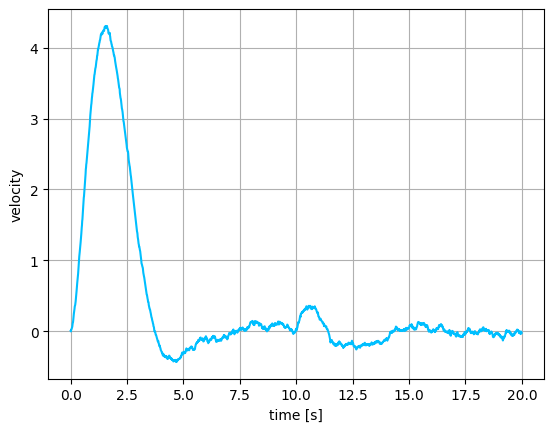

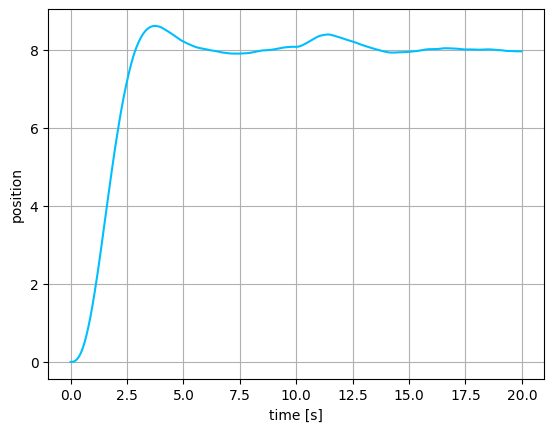

In [71]:
#closed loop step response with noisy state
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))


error_sum = numpy.zeros((2, 1))

for i in range(steps):
    u = numpy.ones((1, 1))

    # add noise for controller, to simulate sensor noise
    x_noised = x + 0.25*numpy.random.randn(2, 1)

    #error and integral action
    error = xr - x_noised
    error_sum+= error*dt

    #apply LQR control law
    u = -k@x_noised + ki@error_sum


    # disturbance in middle
    if i > steps//2:
        u+= 1


    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()